In [10]:
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.cubehelix_palette(6, start=.5, rot=-.75))

from sklearn.model_selection import (train_test_split, KFold, GridSearchCV)

from sklearn.metrics import (roc_auc_score, roc_curve)

# machine learning libraries
from xgboost import XGBClassifier

import utils
from preprocessing import (format_columns, 
                           create_cohort, 
                           create_target, 
                           drop_anomalous_cycles,
                           encode_columns)

from modelling import (create_training_test,
                       fit_model,
                       tune_model)

colors = sns.color_palette()

age_groups = ['18-34', '35-37', '38-39', '40-42', '43-44', '45-50']

AttributeError: module 'seaborn' has no attribute 'grays_palette'

# Notebook introduction

This notebook shows an example model development in support of the publication *'Accurately predicting patients’ chance of cryopreservation during Covid-19 pandemic - can machine-learning models help?'*. In it we use publically available data (see data availability section) to develop machine-learning models to predict the chance of an IVF/ICSI cycle yielding a D5 embryo suitable for cryopreservation or transfer.



## Data availability 

Presented graphs and models were constructed using the 2015-2016 Anonymised register data of fertility treatment cycles performed in the UK, collated and released by the Human Fertilisation and Embryo Authority. It is freely available from their [website](https://www.hfea.gov.uk/about-us/our-data/).

# 0. Load the data and create the cohort

In [3]:
df = pd.read_csv('data/ar-2015-2016.csv')

print(df.shape)

df = (df.pipe(format_columns)
        .pipe(create_cohort)
        .pipe(create_target)
        .pipe(drop_anomalous_cycles))

print(df.shape)

c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7,29,31,32,43,48,50,51,52,53,54,77,83,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(158519, 95)
(86169, 96)


## 0.1 Number of patients in each class

In [4]:
df.groupby('target')['Patient Age at Treatment'].count()

target
0.0    37455
1.0    48714
Name: Patient Age at Treatment, dtype: int64

## 0.2 Number of patients in each age group

In [5]:
df.groupby('Patient Age at Treatment')['target'].count()

Patient Age at Treatment
18-34    37063
35-37    19925
38-39    12862
40-42    12103
43-44     3247
45-50      969
Name: target, dtype: int64

# 1 Initial data analysis

## 1.1 Number of eggs collected by age group

Outliers are not shown since the distributions have long tails.

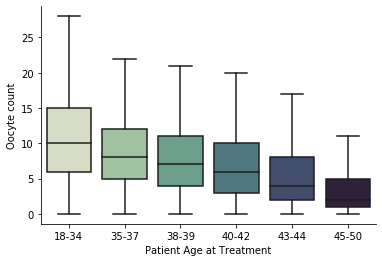

In [6]:
fig, ax = plt.subplots()
sns.boxplot(x='Patient Age at Treatment', y='Fresh Eggs Collected', ax=ax, data=df,
           order=age_groups, showfliers=False)
ax.set_ylabel('Oocyte count')
utils.remove_axes(ax)
plt.savefig('images/eggs_collected_by_age.png', dpi=300, bbox_inches='tight')

## 1.2 Proportion of patients with suitable embryos by oocyte count

Panel a, Non-linear relation between number of embryos suitable for D5 transfer or freezing and the occyte count (number of eggs collected).

Panel b, highlights that age is an additional factor (older patients have a reduced chance of the cycle yielding a suitable embryo, even if they have the same oocyte count as a younger person).

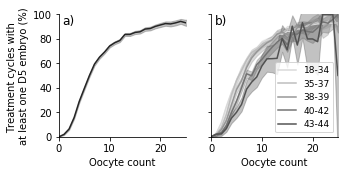

In [21]:
fig, axs = plt.subplots(ncols=2)


# plot for all patients
egg_outcome = df.groupby('Fresh Eggs Collected')['target'].agg(['mean','count'])
mean_error = utils.calculate_proportion_error(egg_outcome['mean'].values, egg_outcome['count'].values)

utils.plot_line_with_confidence(x=egg_outcome.index,
                          y=egg_outcome['mean'].values*100,
                          err=mean_error*100,
                          ax=axs[0], 
                          plot_params={'color':colors[-1], 'lw':1.5},
                          fill_params={'color':colors[-2], 'alpha':0.35})

# plot for segregated by age
for age in enumerate(age_groups[:-1]:
    mask = df['Patient Age at Treatment']==age
    egg_outcome = df[mask].groupby('Fresh Eggs Collected')['target'].agg(['mean','count'])
    mean_error = utils.calculate_proportion_error(egg_outcome['mean'].values, egg_outcome['count'].values)

    utils.plot_line_with_confidence(x=egg_outcome.index,
                              y=egg_outcome['mean'].values*100,
                              err=mean_error*100,
                              ax=axs[1], 
                              plot_params={'label':age, 'lw':1.5, color=colors[i]},
                              fill_params={'alpha':0.35})
    
# tidy up plots and add labels
axs[1].legend(fontsize=9)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[0].set_ylabel('Treatment cycles with \nat least one D5 embryo (%)')
for ax in axs:
    ax.set_xlabel('Oocyte count')
fig.set_size_inches(5,2.25)
axs[0].text(0.75, 92, 'a)', fontsize=12)
axs[1].text(0.75, 92, 'b)', fontsize=12)
plt.savefig('images/cycles_with_suitable_embryos.png', dpi=300, bbox_inches='tight')

## 1.3 Proportion of patients with suitable embryos by age group

In [18]:
colors = ['#f0f0f0',
'#d9d9d9',
'#bdbdbd',
'#969696',
'#737373',
'#525252',
'#252525']

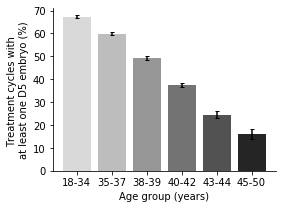

In [19]:
age_grouping = df.groupby('Patient Age at Treatment')['target'].agg(['mean', 'count'])


x = age_grouping.index
y = age_grouping['mean'].values
c = age_grouping['count'].values

errors  = utils.calculate_proportion_error(y, c)

# plot the figure

fig, ax = plt.subplots()

ax.bar(np.arange(0,len(y)), y*100, yerr=errors*100, capsize=2, color=colors[1:])
ax.set_ylabel('Treatment cycles with \nat least one D5 embryo (%)')
utils.remove_axes(ax)

# set the xtick labels
ax.set_xticklabels([''] + age_groups)
ax.set_xlabel('Age group (years)')

fig.set_size_inches(4,3)
plt.savefig('images/cycles_with_embryos_by_age_group.png', dpi=300, bbox_inches='tight')

## 1.4 Proportion of patients with suitable embryos by infertility diagnosis

In [9]:
infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]

c:\users\fpc\envs\ivf\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\fpc\envs\ivf\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


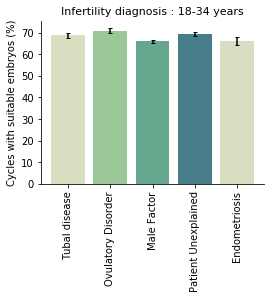

In [11]:
age='18-34'

means = []
errors = []
for col in infertility_columns:
    mask = (df[col]==1) & (df['Patient Age at Treatment']==age)
    infertility_target = df.loc[mask, 'target'].values
    mean_embryos = np.mean(infertility_target)
    count_embryos = len(infertility_target)
    error = utils.calculate_proportion_error(mean_embryos, count_embryos)
    means.append(mean_embryos)
    errors.append(error)
    
# make the figure
xlabels = [col.replace('Cause of Infertility - ', '') for col in infertility_columns]

fig, ax = plt.subplots()
ax.bar(xlabels[:5], np.array(means[:5])*100, yerr=np.array(errors[:5])*100, capsize=2, color=colors[:4])
utils.remove_axes(ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title('Infertility diagnosis : {} years'.format(age), fontsize=11)
ax.set_ylabel('Cycles with suitable embryos (%)')
fig.set_size_inches(4,3)
plt.savefig('images/cycles_with_embryos_by_infertility_diagnosis_{}.png'.format(age), dpi=300, bbox_inches='tight')

# 2 Model development


In [12]:
# basic encoding, so no significant need for this to be performed in-fold.
df = encode_columns(df)

## 2.1 Model 1

In this section we evaluate the performance of a models each trained with only one of the available features.

The features we use are:
    - Patient Age
    - Number of eggs collected
    - Infertility diagnosis (Encoded with one-hot-encoding)
    
   
Models are evaluted using cross-validation on training set only. 


The infertility columns show a small amount of promise, but this maybe because they latently encode age  - for example patients with ovulatory disorder are more likely to present for fertility treatment at a younger age.

In [15]:
infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + [infertility_columns[:5]]

In [17]:
nfolds = 5

for feature in features:
    X, _, y, _ = create_training_test(df, features=feature, seed=123) # seed ensure same training set
    cv_scores = np.zeros(nfolds)
    trn_scores = np.zeros(nfolds)
    cv_splitter = KFold(n_splits=nfolds)
    for i, (trn_idx, val_idx) in enumerate(cv_splitter.split(X)):
        X_trn, X_val = X[trn_idx], X[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]
        clf = XGBClassifier()
        # reshape X if only one feature
        try:
            X_trn.shape[1]
        except:
            X_trn = X_trn.reshape((-1,1))
            X_val = X_val.reshape((-1,1))
        clf.fit(X_trn, y_trn)
        trn_preds = clf.predict_proba(X_trn)[:,1]
        val_preds = clf.predict_proba(X_val)[:,1]
        trn_scores[i] = roc_auc_score(y_trn, trn_preds)
        cv_scores[i] = roc_auc_score(y_val, val_preds)
    print('---'*5)
    print(f'{feature}')
    print(f'Train AUROC: {np.mean(trn_scores):.3f} +/- {(1.96/(nfolds)**0.5)*np.std(trn_scores):.3f}')
    print(f'Validation AUROC: {np.mean(cv_scores):.3f} +/- {(1.96/(nfolds)**0.5)*np.std(cv_scores):.3f}')

---------------
Patient Age at Treatment
Train AUROC: 0.637 +/- 0.001
Validation AUROC: 0.637 +/- 0.003
---------------
Fresh Eggs Collected
Train AUROC: 0.839 +/- 0.001
Validation AUROC: 0.839 +/- 0.004
---------------
['Cause of Infertility - Tubal disease', 'Cause of Infertility - Ovulatory Disorder', 'Cause of Infertility - Male Factor', 'Cause of Infertility - Patient Unexplained', 'Cause of Infertility - Endometriosis']
Train AUROC: 0.563 +/- 0.001
Validation AUROC: 0.562 +/- 0.005


### 2.2 Model 2

Two feature (Age and number of eggs/oocytes collected) model evaluted on the training and validation set.


In [22]:
features = ['Patient Age at Treatment','Fresh Eggs Collected']

In [23]:
nfolds = 5
X, _, y, _ = create_training_test(df, features=features, seed=123) # seed ensure same training set
cv_scores = np.zeros(nfolds)
trn_scores = np.zeros(nfolds)
cv_splitter = KFold(n_splits=nfolds)
for i, (trn_idx, val_idx) in enumerate(cv_splitter.split(X)):
    X_trn, X_val = X[trn_idx], X[val_idx]
    y_trn, y_val = y[trn_idx], y[val_idx]
    clf = XGBClassifier()
    clf.fit(X_trn, y_trn)
    trn_preds = clf.predict_proba(X_trn)[:,1]
    val_preds = clf.predict_proba(X_val)[:,1]
    trn_scores[i] = roc_auc_score(y_trn, trn_preds)
    cv_scores[i] = roc_auc_score(y_val, val_preds)
print('---'*5)
print(f'Train AUROC: {np.mean(trn_scores):.3f} +/- {(1.96/(nfolds)**0.5)*np.std(trn_scores):.3f}')
print(f'Validation AUROC: {np.mean(cv_scores):.3f} +/- {(1.96/(nfolds)**0.5)*np.std(cv_scores):.3f}')

---------------
Train AUROC: 0.648 +/- 0.001
Validation AUROC: 0.647 +/- 0.004


## 2.3  Model 3

Looking at a model including all three features.

Infertility diagnosis appears to add a very small improvement, but not necessarily significant. We will include it since it is unlikely to be deterimental to the final model evaluation.

In [30]:
features = ['Patient Age at Treatment', 'Fresh Eggs Collected'] + infertility_columns[:5]

In [31]:
nfolds = 5
X, _, y, _ = create_training_test(df, features=features, seed=123) # seed ensure same training set
cv_scores = np.zeros(nfolds)
trn_scores = np.zeros(nfolds)
cv_splitter = KFold(n_splits=nfolds)
for i, (trn_idx, val_idx) in enumerate(cv_splitter.split(X)):
    X_trn, X_val = X[trn_idx], X[val_idx]
    y_trn, y_val = y[trn_idx], y[val_idx]
    clf = XGBClassifier()
    clf.fit(X_trn, y_trn)
    trn_preds = clf.predict_proba(X_trn)[:,1]
    val_preds = clf.predict_proba(X_val)[:,1]
    trn_scores[i] = roc_auc_score(y_trn, trn_preds)
    cv_scores[i] = roc_auc_score(y_val, val_preds)
print('---'*5)
print(f'Train AUROC: {np.mean(trn_scores):.3f} +/- {(1.96/(nfolds)**0.5)*np.std(trn_scores):.3f}')
print(f'Validation AUROC: {np.mean(cv_scores):.3f} +/- {(1.96/(nfolds)**0.5)*np.std(cv_scores):.3f}')

---------------
Train AUROC: 0.845 +/- 0.001
Validation AUROC: 0.844 +/- 0.003


# 3. Hyperparameter tuning and final model evaluation

With only three features, an XGBoost model is overkill, but we can control complexity with n_estimators and max_depth parameters.

In [32]:
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + infertility_columns[:5]

In [33]:
param_grid =  {'max_depth':[2,3,4],'subsample':[1,0.9, 0.8], 'gamma':[1,5,10,25], 'learning_rate':[0.05,0.025,0.1], 'n_estimators':[75,100, 125]}

In [34]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)

hyperparameters = tune_model(X, y, param_grid=param_grid)

In [35]:
hyperparameters.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

# 3.1 Train the final model

- Bootstrapping is performed and the model evaluated on the hold-out test
- Best hyperparameters on the validation set are used.

In [36]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 250
scores = np.zeros(ncycles)
yt_preds_list = []
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold, params=hyperparameters.best_params_)
    yt_preds = np.zeros(len(Xt))
    for model in models:
        yt_preds += model.predict_proba(Xt)[:,1]/len(models)
    scores[i] = roc_auc_score(yt, yt_preds)
    yt_preds_list.append(yt_preds)
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

np.save('results/y_preds_xgboost.npy', yt_preds_list)

----*----
AUROC: 0.841 CI: 0.840-0.841


## 3.2 Figures of merit on hold-out test set

We plot the ROC curve for the model evaluated on the hold-out test set and a probabilty calibration curve, which shows that the models predicted probabilties reflect the actual chance of the event occuring.

In [37]:
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + infertility_columns[:5]

In [38]:
X, Xt, y, yt = create_training_test(df, features=features, seed=123) 

## Fit example, single model with no bootstrapping

models, score = fit_model(X, y, cv_splitter=KFold, params=hyperparameters.best_params_)

In [39]:
# predicton the hold-out test-set
yt_preds = np.zeros(len(Xt))
for clf in models:
    yt_preds += clf.predict_proba(Xt)[:,1]/len(models)

In [40]:
# create prediction calibration data for figure

pred_df = pd.DataFrame({'preds': yt_preds*100, 'target':yt*100})
pred_df['binned_preds'] = pd.cut(pred_df['preds'], bins=np.arange(0, 105, 5))
grouping = pred_df.groupby('binned_preds').aggregate(['mean', 'std', 'count'])['target']
grouping['mean_error'] = grouping['std']/ grouping['count']**0.5

# create ROC curve
bs_preds = np.load('results/y_preds_xgboost.npy')
fpr, tpr, _ = roc_curve(yt, np.mean(bs_preds, axis=0))

# calculate bootstrap confidence intervals
scores = np.zeros(250)
for i in range(250):
    scores[i] = roc_auc_score(yt, bs_preds[i])
ci = utils.confidence_intervals(scores)

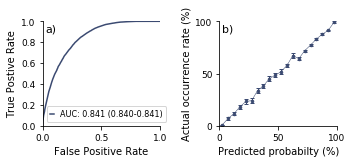

In [45]:
fig, axs = plt.subplots(ncols=2)


# plot ROC curve
axs[0].plot(fpr, tpr, color=colors[-2], label=f'AUC: {np.mean(scores):.3f} ({ci[0]:.3f}-{ci[1]:.3f})')
axs[0].legend(fontsize=8, handlelength=0.5)
axs[0].set_ylabel('True Postive Rate')
axs[0].set_xlabel('False Positive Rate')

# plot calibration figure
axs[1].errorbar(x=[interval.mid for interval in grouping.index], 
                y=grouping['mean'], 
                yerr=grouping['mean_error'],
                color=colors[-2],
                lw=0.5,
                elinewidth=1,
                capsize=2,
                marker='.',
                markersize=5)
axs[1].set_xlabel('Predicted probabilty (%)')
axs[1].set_ylabel('Actual occurrence rate (%)')

# tidy up the plots
for ax, lim in zip(axs, [(0,1),(0,100)]):
    plt.setp(ax.get_yticklabels(), fontsize=9)
    plt.setp(ax.get_xticklabels(), fontsize=9)
    utils.remove_axes(ax)
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
axs[1].set_xticks([0,50,100])
axs[1].set_yticks([0,50,100])
    
axs[0].text(0.025, 0.9, 'a)', fontsize=11)
axs[1].text(2.5, 90, 'b)', fontsize=11)

fig.set_size_inches(5, 2.25)
plt.tight_layout()
plt.savefig('images/HFEA_model_evaluation.png', dpi=300, bbox_inches='tight')